In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.metrics import accuracy_score

%matplotlib inline

np.random.seed(1) 
COMMON_PATH = ""

In [2]:
x_train = pd.read_csv(COMMON_PATH + "Task_2/x_train.csv", header=None)
y_train_t = pd.read_csv(COMMON_PATH + "Task_2/y_train.csv", header=None)
x_test = pd.read_csv(COMMON_PATH + "Task_2/x_test.csv", header=None)
y_test_t = pd.read_csv(COMMON_PATH + "Task_2/y_test.csv", header=None)
y_train = pd.get_dummies(y_train_t[0], dtype=int)
y_test = pd.get_dummies(y_test_t[0], dtype=int)

x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

In [3]:
def relu(x):
	return x * (x > 0)

def relu_derivative(x):
	return 1. * (x > 0)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

In [4]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0] # size of input layer
    n_h_1 = 100
    n_h_2 = 40
    n_y = Y.shape[0] # size of output layer
    return (n_x, n_h_1, n_h_2, n_y)

In [5]:
def load_weights_and_biases(folder="a"):
    weights_path = COMMON_PATH + "Task_1/a/w.csv"
    biases_path = COMMON_PATH + "Task_1/a/b.csv"
        
    if folder == "b":
        weights_path = COMMON_PATH + "Task_1/b/w-100-40-4.csv"
        biases_path = COMMON_PATH + "Task_1/b/b-100-40-4.csv"
        
    weights_csv = pd.read_csv(weights_path, header=None)
    weights_csv = weights_csv.iloc[: , 1:]

    W1_test = weights_csv[0:14]
    W1_test = W1_test.to_numpy()
    W1_test = W1_test.T

    W2_test = weights_csv[14:114]
    W2_test = W2_test.iloc[: , :-60]
    W2_test = W2_test.to_numpy()
    W2_test = W2_test.T

    W3_test = weights_csv[114:]
    W3_test = W3_test.iloc[: , :-96]
    W3_test = W3_test.to_numpy()
    W3_test = W3_test.T

    bias_csv = pd.read_csv(biases_path, header=None)
    bias_csv = bias_csv.iloc[: , 1:]

    b1_test = bias_csv[0:1]
    b1_test = b1_test.to_numpy()
    b1_test = b1_test.T

    b2_test = bias_csv[1:2]
    b2_test = b2_test.iloc[: , :-60]
    b2_test = b2_test.to_numpy()
    b2_test = b2_test.T

    b3_test = bias_csv[2:3]
    b3_test = b3_test.iloc[: , :-96]
    b3_test = b3_test.to_numpy()
    b3_test = b3_test.T
    
    parameters = {"W1": W1_test,
                  "b1": b1_test,
                  "W2": W2_test,
                  "b2": b2_test,
                  "W3": W3_test,
                  "b3": b3_test
                 }
    
    return parameters

In [6]:
def initialize_parameters(n_x, n_h_1, n_h_2, n_y, test=False, test_folder="a"):
    """
    Argument:
    n_x -- size of the input layer
    n_h_1 -- size of the hidden layer 1
    n_h_2 -- size of the hidden layer 2
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h_1, n_x)
                    b1 -- bias vector of shape (n_h_1, 1)
                    W2 -- weight matrix of shape (n_h_2, n_h_1)
                    b2 -- bias vector of shape (n_h_2, 1)
                    W3 -- weight matrix of shape (n_y, n_h_2)
                    b3 -- bias vector of shape (n_y, 1)
    """
    
    W1 = np.random.randn(n_h_1, n_x) * 0.01
    b1 = np.zeros((n_h_1, 1))
    W2 = np.random.randn(n_h_2, n_h_1) * 0.01
    b2 = np.zeros((n_h_2, 1))
    W3 = np.random.randn(n_y, n_h_2) * 0.01
    b3 = np.zeros((n_y, 1))
    
    if test == True:
        test_params = load_weights_and_biases(folder=test_folder)
        W1 = test_params["W1"]
        b1 = test_params["b1"]
        W2 = test_params["W2"]
        b2 = test_params["b2"]
        W3 = test_params["W3"]
        b3 = test_params["b3"]
    
    assert (W1.shape == (n_h_1, n_x))
    assert (b1.shape == (n_h_1, 1))
    assert (W2.shape == (n_h_2, n_h_1))
    assert (b2.shape == (n_h_2, 1))
    assert (W3.shape == (n_y, n_h_2))
    assert (b3.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3
                 }
    
    return parameters

In [7]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # Implement Forward Propagation to calculate A3 (probabilities)
    Z1 = np.dot(W1,X) + b1
    A1 = relu(Z1)
    
    Z2 = np.dot(W2,A1) + b2
    A2 = relu(Z2)
    
    Z3 = np.dot(W3,A2) + b3
    A3 = softmax(Z3)

    assert(A3.shape == (4, X.shape[1]))
    
    # Values needed in the backpropagation are stored in "cache". This will be given as an input to the backpropagation
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2,
             "Z3": Z3,
             "A3": A3,
            }
    
    return A3, cache

In [8]:
def compute_cost(A3, Y):
    """
    Computes the cross-entropy cost
    
    Arguments:
    A3 -- The sigmoid output of the second activation, of shape (4, number of examples)
    Y -- "true" labels vector of shape (4, number of examples)
    
    Returns:
    cost -- cross-entropy cost
    
    """
    
    m = Y.shape[1] # number of example

    cost = -np.einsum('Bi,Bi',Y, np.log(A3)) * (1/m)    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [9]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2", "A2", "Z3" and "A3".
    X -- input data of shape (14, number of examples)
    Y -- "true" labels vector of shape (4, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    A3 = cache["A3"]
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]
    Z3 = cache["Z3"]
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ3 = A3 - Y
    dW3 = (1/m) * np.dot(dZ3, A2.T)
    db3 = (1/m) * np.sum(dZ3, axis=1, keepdims=True)
    
    dZ2 = np.dot(W3.T, dZ3) * relu_derivative(Z2) # Assuming ReLU activation in the second hidden layer
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = np.dot(W2.T, dZ2) * relu_derivative(Z1) # Assuming ReLU activation in the first hidden layer
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2,
             "dW3": dW3,
             "db3": db3,
            }
    
    return grads

In [10]:
def update_parameters(parameters, grads, learning_rate):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    dW3 = grads["dW3"]
    db3 = grads["db3"]
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W3 = W3 - learning_rate * dW3
    b3 = b3 - learning_rate * db3
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                 }
    
    return parameters

In [11]:
def calc_accuracy_helper(y_true, y_pred):
    pred = y_pred.copy()
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0
    pred = np.argmax(pred.T, axis=1)
    pred = pd.DataFrame(pred)
    
    return accuracy_score(y_true, pred)

In [12]:
def predict(parameters, X, threshold=0.5, cutoff=True):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A3, cache = forward_propagation(X, parameters)
    predictions = A3
    
    if cutoff == True:
        predictions[predictions >= 0.5] = 1
        predictions[predictions < 0.5] = 0
    
    return predictions

In [13]:
# NN_model
def nn_model(X, Y, n_h_1, n_h_2, learning_rate, num_iterations = 10000, print_cost=False, test=False, test_folder="a"):
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[3]
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h_1, n_h_2, n_y, test, test_folder)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    training_cost = []
    testing_cost = []
    train_accuracy_scores = []
    test_accuracy_scores = []
    
    n_plot = 100 # Choose after how many iterations to plot
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache"
        A3, cache = forward_propagation(X, parameters)
        if i % n_plot == 0:
            train_accuracy_scores.append((i,calc_accuracy_helper(y_train_t,A3)))
            test_pred = predict(parameters, x_test.T, cutoff=False)
            testing_cost.append((i,compute_cost(test_pred, y_test.T)))
            test_accuracy_scores.append((i,calc_accuracy_helper(y_test_t, test_pred)))
        
        # Cost function. Inputs: "A2, Y". Outputs: "cost"
        cost = compute_cost(A3, Y)
        if i % n_plot == 0:
            training_cost.append((i,cost))
        
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads"
        grads = backward_propagation(parameters, cache, X, Y)
    
        # Update rule for each parameter
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # If print_cost=True, Print the cost every 1000 iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    iterations, train_costs = zip(*training_cost)
    iterations, train_scores = zip(*train_accuracy_scores)
    iterations, test_costs = zip(*testing_cost)
    iterations, test_scores = zip(*test_accuracy_scores)

    # Create subplots with two graphs side by side
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot Training Cost
    axs[0, 0].plot(iterations, train_costs, marker='o', linestyle='-')
    axs[0, 0].set_xlabel('Iterations')
    axs[0, 0].set_ylabel('Training Cost')
    axs[0, 0].set_title(f'Training Cost (LR={learning_rate})')

    # Plot Train Accuracy
    axs[0, 1].plot(iterations, train_scores, marker='o', linestyle='-')
    axs[0, 1].set_xlabel('Iterations')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].set_title(f'Train Accuracy (LR={learning_rate})')
    
    # Plot Testing Cost
    axs[1, 0].plot(iterations, test_costs, marker='o', linestyle='-')
    axs[1, 0].set_xlabel('Iterations')
    axs[1, 0].set_ylabel('Training Cost')
    axs[1, 0].set_title(f'Testing Cost (LR={learning_rate})')
    
    # Plot Test Accuracy
    axs[1, 1].plot(iterations, test_scores, marker='o', linestyle='-')
    axs[1, 1].set_xlabel('Iterations')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].set_title(f'Test Accuracy (LR={learning_rate})')

    plt.tight_layout()  # Ensures proper spacing between subplots
    fig.savefig(f'plot-{learning_rate}.png', dpi=300)
            
    # Returns parameters learnt by the model. They can then be used to predict output
    return parameters, grads

In [14]:
def compare_grads(grads):
    true_db = pd.read_csv(COMMON_PATH + "Task_1/a/true-db.csv", header=None)

    db1_test = true_db[0:1]
    db1_test = db1_test.to_numpy()
    db1_test = db1_test.T

    db2_test = true_db[1:2]
    db2_test = db2_test.iloc[: , :-60]
    db2_test = db2_test.to_numpy()
    db2_test = db2_test.T

    db3_test = true_db[2:3]
    db3_test = db3_test.iloc[: , :-96]
    db3_test = db3_test.to_numpy()
    db3_test = db3_test.T

    print("db1 : ", np.array_equal(np.round(grads["db1"], 8), np.round(db1_test, 8)))
    print("db2 : ", np.array_equal(np.round(grads["db2"], 8), np.round(db2_test, 8)))
    print("db3 : ", np.array_equal(np.round(grads["db3"], 16), np.round(db3_test, 16)))
    
    true_dw = pd.read_csv(COMMON_PATH + "Task_1/a/true-dw.csv", header=None)

    dW1_test = true_dw[0:14]
    dW1_test = dW1_test.to_numpy()
    dW1_test = dW1_test.T

    dW2_test = true_dw[14:114]
    dW2_test = dW2_test.iloc[: , :-60]
    dW2_test = dW2_test.to_numpy()
    dW2_test = dW2_test.T

    dW3_test = true_dw[114:]
    dW3_test = dW3_test.iloc[: , :-96]
    dW3_test = dW3_test.to_numpy()
    dW3_test = dW3_test.T

    print("dW1 : ", np.array_equal(np.round(grads["dW1"], 8), np.round(dW1_test, 8)))
    print("dW2 : ", np.array_equal(np.round(grads["dW2"], 8), np.round(dW2_test, 8)))
    print("dW3 : ", np.array_equal(np.round(grads["dW3"], 8), np.round(dW3_test, 8)))

In [15]:
def save_grads(grads):
    n = 16
    
    dW1_df = pd.DataFrame(grads["dW1"].T)
    dW2_df = pd.DataFrame(grads["dW2"].T)
    dW3_df = pd.DataFrame(grads["dW3"].T)
    
    dW1_df.round(n)
    dW2_df.round(n)
    dW3_df.round(n)
    
    filename = "dw.csv"
    dW1_df.to_csv(filename, index=False, header=False)
    with open(filename, "ab") as f:
        dW2_df.to_csv(f, index=False, header=False)
        dW3_df.to_csv(f, index=False, header=False)
        
    db1_df = pd.DataFrame(grads["db1"].T)
    db2_df = pd.DataFrame(grads["db2"].T)
    db3_df = pd.DataFrame(grads["db3"].T)
    
    db1_df.round(n)
    db2_df.round(n)
    db3_df.round(n)
    
    filename = "db.csv"
    db1_df.to_csv(filename, index=False, header=False)
    with open(filename, "ab") as f:
        db2_df.to_csv(f, index=False, header=False)
        db3_df.to_csv(f, index=False, header=False)

Cost after iteration 0: 1.386293
Cost after iteration 1000: 0.107601
Cost after iteration 2000: 0.011095
Cost after iteration 4000: 0.001133
Cost after iteration 5000: 0.000739
Cost after iteration 6000: 0.000541
Cost after iteration 7000: 0.000423
Cost after iteration 8000: 0.000346
Cost after iteration 9000: 0.000291


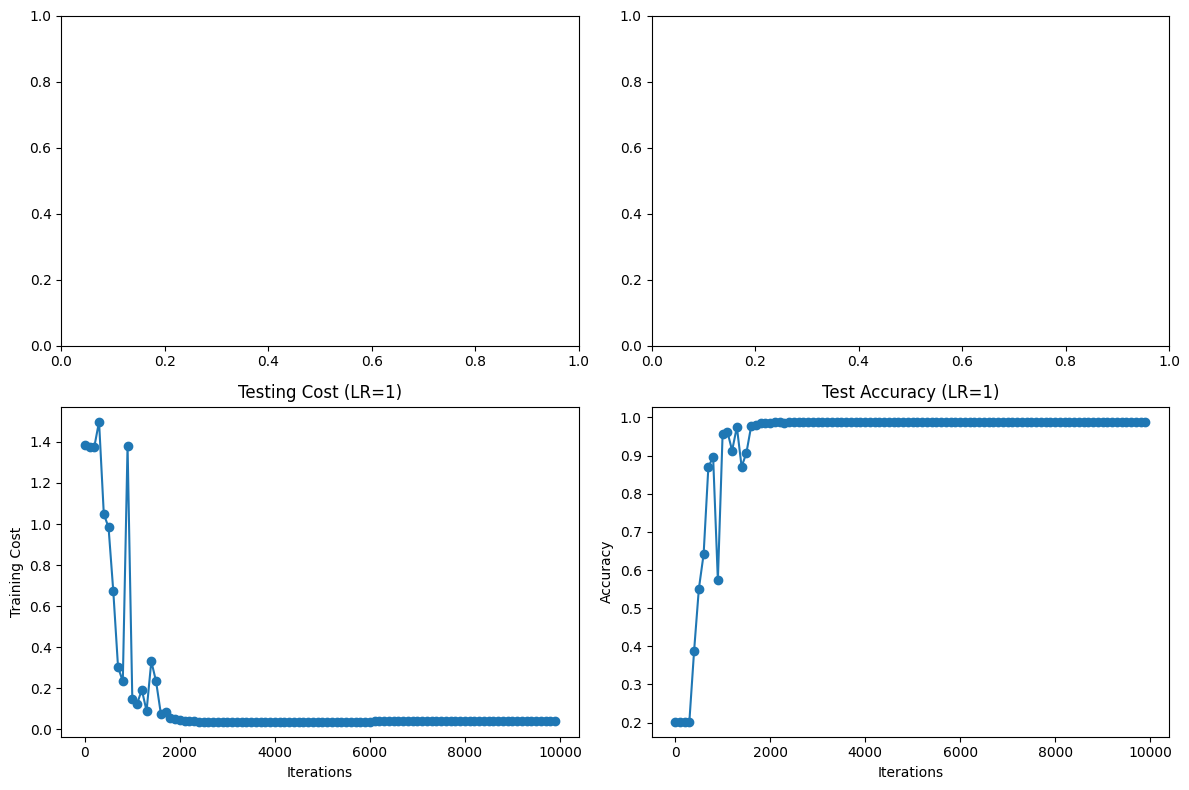

In [16]:
parameters, grads = nn_model(x_train.T, y_train.T, 100, 40, 1, num_iterations=10000, print_cost=True)

In [ ]:
parameters, grads = nn_model(x_train.T, y_train.T, 100, 40, 0.1, num_iterations=10000, print_cost=True)

Cost after iteration 0: 1.386293
Cost after iteration 100: 1.385840
Cost after iteration 200: 1.385410
Cost after iteration 300: 1.385000
Cost after iteration 400: 1.384611
Cost after iteration 500: 1.384240
Cost after iteration 600: 1.383888
Cost after iteration 700: 1.383552
Cost after iteration 800: 1.383232
Cost after iteration 900: 1.382928
Cost after iteration 1000: 1.382639
Cost after iteration 1100: 1.382364
Cost after iteration 1200: 1.382101
Cost after iteration 1300: 1.381852
Cost after iteration 1400: 1.381614
Cost after iteration 1500: 1.381388
Cost after iteration 1600: 1.381172
Cost after iteration 1700: 1.380967
Cost after iteration 1800: 1.380771
Cost after iteration 1900: 1.380585
Cost after iteration 2000: 1.380407
Cost after iteration 2100: 1.380238
Cost after iteration 2200: 1.380077
Cost after iteration 2300: 1.379924
Cost after iteration 2400: 1.379778
Cost after iteration 2500: 1.379639
Cost after iteration 2600: 1.379506
Cost after iteration 2700: 1.379379
Cost

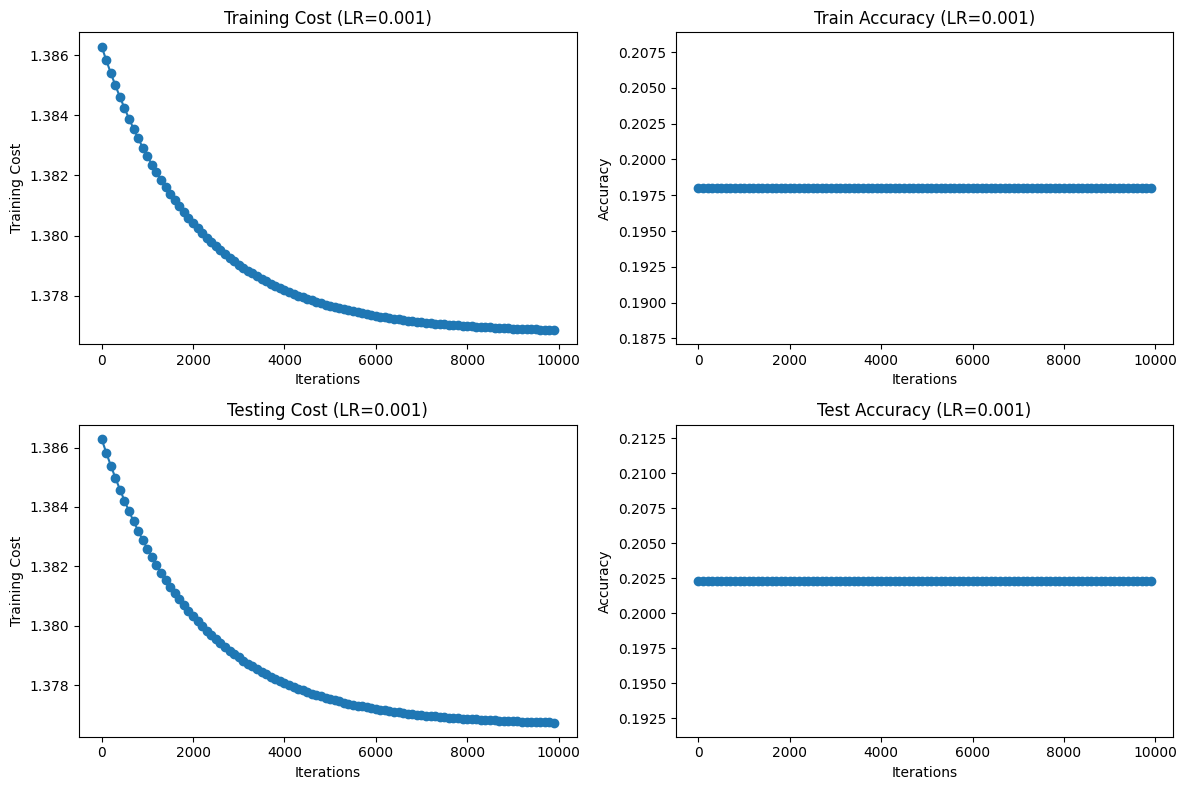

In [16]:
parameters, grads = nn_model(x_train.T, y_train.T, 100, 40, 0.001, num_iterations=10000, print_cost=True)

In [17]:
predictions = predict(parameters, x_test.T)
predictions = np.argmax(predictions.T, axis=1)
predictions = pd.DataFrame(predictions)

In [18]:
accuracy_score(y_test_t, predictions)

0.20231919438510834

In [455]:
# X = np.array([-1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1]).reshape(-1, 1)
# Y = np.array([0, 0, 0, 1]).reshape(-1, 1)

# parameters, grads = nn_model(X, Y, 100, 40, 1, num_iterations=1, print_cost=True, test=True, test_folder="a")
# compare_grads(grads)
# # save_grads(grads)